In [1]:
import bz2
import os
import os.path as osp
import sys
import cv2

import dlib
import numpy as np
from PIL import Image
import requests
import scipy.ndimage
from tqdm import tqdm

LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = dlib.get_frontal_face_detector(
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print('cached')
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = '%s.jpg' % (os.path.splitext(img_name)[0], )
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path,
                aligned_face_path,
                face_landmarks,
                output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print('cached')
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, 'wb').write(file.content)
    return tgt

In [3]:
landmarks_model_path = unpack_bz2(
    get_file(
        'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2',
        'temp/shape_predictor_68_face_landmarks.dat.bz2'))

cached
cached


In [4]:
img_dir = 'imgs_align/'
dst_dir = 'imgs_test/imgs_faceless/'
if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
dir_list = sorted(os.listdir(img_dir))
for i,file in enumerate(dir_list):
    print(f'{i}: {file}')

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: idPhoto.png
8: mio_happy.png
9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_smile.png
35: yotaka_smile2.png


In [88]:
# [from,to]の順で２画像選択
indices = [15,14]
IMAGES = []
IMAGES_NAME = []
LANDMARKS = []
for i in indices:
    img_path = img_dir + dir_list[i]
    img_name = os.path.splitext(dir_list[i])[0]
    if not os.path.exists(dst_dir+img_name):
        os.makedirs(dst_dir+img_name)
    IMAGES_NAME.append(img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    IMAGES.append(img)
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    landmark = landmarks_detector.get_landmarks(img_path)
    LANDMARKS.append(landmark)

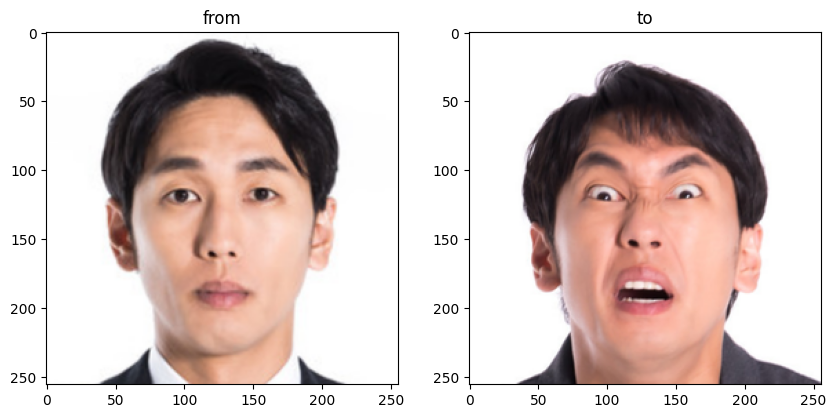

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
title = ['from', 'to']
for i in range(2):
    ax[i].imshow(IMAGES[i])
    # ax[i].axis('off')
    ax[i].set_title(title[i])

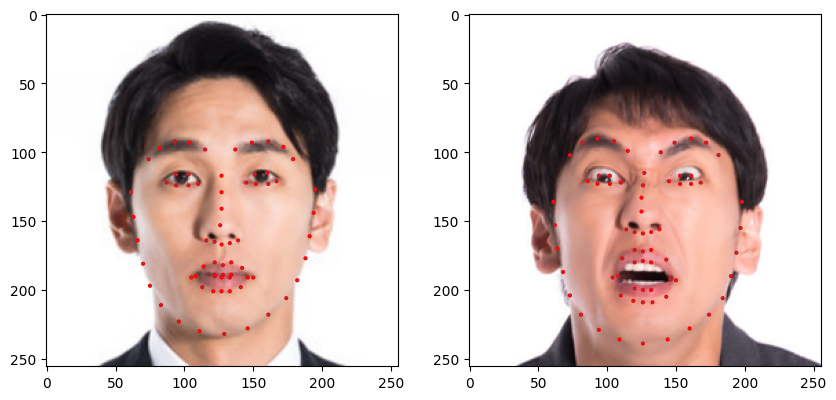

In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1,2, figsize=(10, 5))
for i,land in enumerate(LANDMARKS):
    ax[i].imshow(IMAGES[i])
    for la in land:
        r = patches.Circle(xy=la, radius=1, ec='r')
        ax[i].add_patch(r)

plt.show()

In [91]:
lm = np.array(LANDMARKS)
lm_eyebrow_left = lm[:,17:22]  # left-right
lm_eyebrow_right = lm[:,22:27]  # left-right
lm_nose = lm[:,27:31]  # top-down
lm_nostrils = lm[:,31:36]  # top-down
lm_eye_left = lm[:,36:42]  # left-clockwise
lm_eye_right = lm[:,42:48]  # left-clockwise
lm_mouth_outer = lm[:,48:60]  # left-clockwise
lm_mouth_inner = lm[:,60:68]  # left-clockwise

## All

In [92]:
img_from = IMAGES[0].copy()
img_to = IMAGES[1].copy()
pt_from = np.concatenate([lm[0,:17], np.flipud(lm[0,17:27])])
pt_to = np.concatenate([lm[1,:17], np.flipud(lm[1,17:27])])

In [93]:
# pt_from
pt_from_center = pt_from.sum(axis=0)//len(pt_from)
for i in range(17):
    if pt_from[i][0] < pt_from_center[0]:
        pt_from[i][0] += 3
    else:
        pt_from[i][0] -= 3
    
    if pt_from[i][1] < pt_from_center[1]:
        pt_from[i][1] += 3
    else:
        pt_from[i][1] -= 3 

for i in range(17, 27):
    pt_from[i][1] -= 8

# pt_to
pt_to_center = pt_to.sum(axis=0)//len(pt_to)
for i in range(17):
    if pt_to[i][0] < pt_to_center[0]:
        pt_to[i][0] += 3
    else:
        pt_to[i][0] -= 3
    
    if pt_to[i][1] < pt_to_center[1]:
        pt_to[i][1] += 3
    else:
        pt_to[i][1] -= 3 

for i in range(17, 27):
    pt_to[i][1] -= 8

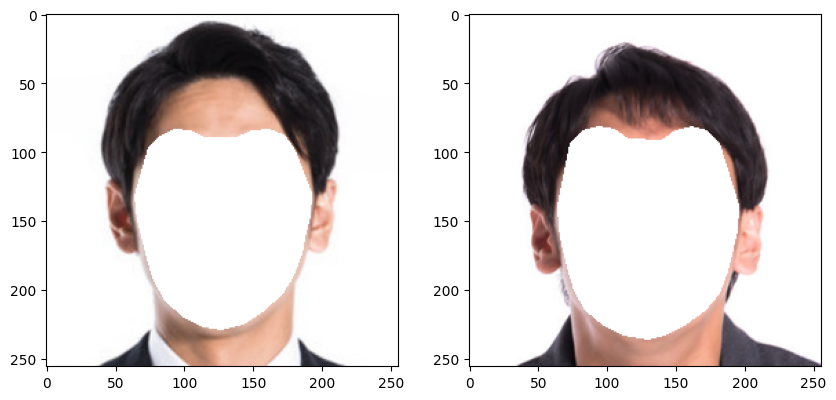

In [94]:
import matplotlib.pyplot as plt

fill_color = (255,255,255)
cv2.fillPoly(img_from, [pt_from], fill_color)
cv2.fillPoly(img_to, [pt_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_from)
ax[1].imshow(img_to)

plt.show()

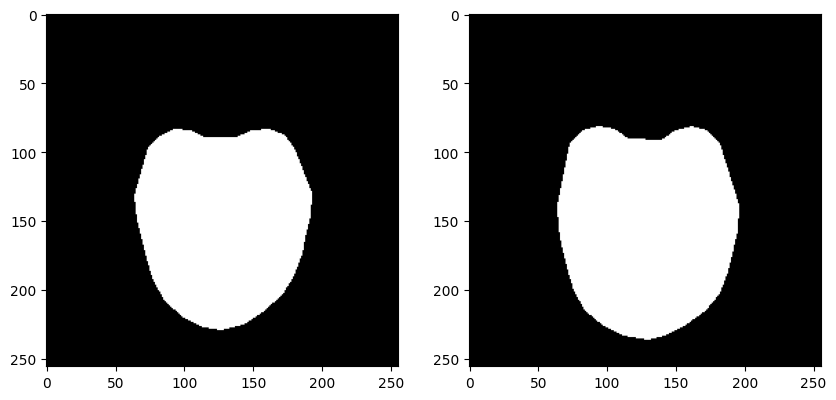

In [95]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_from = cv2.fillPoly(mask.copy(), [pt_from], (255,255,255))
mask_to = cv2.fillPoly(mask.copy(), [pt_to], (255,255,255))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_from)
ax[1].imshow(mask_to)
plt.show()

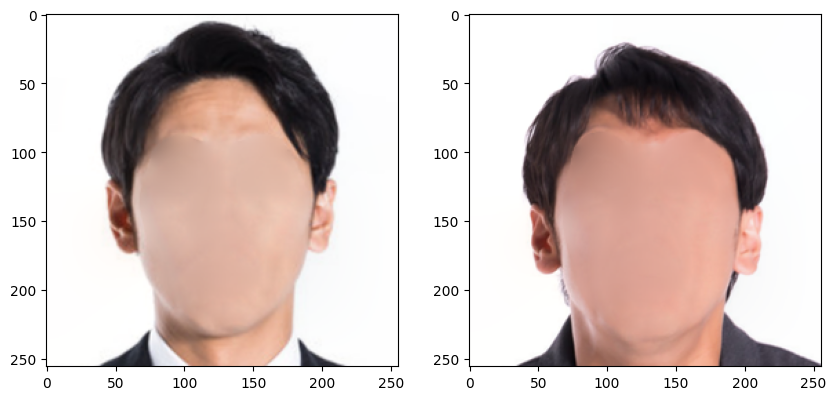

In [96]:
faceless_from = cv2.illuminationChange(IMAGES[0], mask_from, alpha = 1.5, beta = 2)
faceless_to = cv2.illuminationChange(IMAGES[1], mask_to, alpha = 1.5, beta = 2)                          

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(faceless_from)
ax[1].imshow(faceless_to)
plt.show()

In [97]:
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[0]}/faceless.png',
            cv2.cvtColor(faceless_from, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[1]}/faceless.png',
            cv2.cvtColor(faceless_to, cv2.COLOR_RGB2BGR));

## Eye

In [98]:
img_eye_from = IMAGES[0].copy()
img_eye_to = IMAGES[1].copy()
pt_eye_left_from = np.vstack([lm[0,17:22], lm[0,39:42], lm[0,36]])
pt_eye_right_from = np.vstack([lm[0,22:27], lm[0,45:48], lm[0,42]])
pt_eye_left_to = np.vstack([lm[1,17:22], lm[1,39:42], lm[1,36]])
pt_eye_right_to = np.vstack([lm[1,22:27], lm[1,45:48], lm[1,42]])

In [99]:
pt_eye_left_from_center = pt_eye_left_from.sum(axis=0)//len(pt_eye_left_from)
for i in range(len(pt_eye_left_from)):
    if pt_eye_left_from[i][0] < pt_eye_left_from_center[0]:
        pt_eye_left_from[i][0] -= 8
    else:
        pt_eye_left_from[i][0] += 8
    
    if pt_eye_left_from[i][1] < pt_eye_left_from_center[1]:
        pt_eye_left_from[i][1] -= 8
    else:
        pt_eye_left_from[i][1] += 13

pt_eye_right_from_center = pt_eye_right_from.sum(axis=0)//len(pt_eye_right_from)
for i in range(len(pt_eye_right_from)):
    if pt_eye_right_from[i][0] < pt_eye_right_from_center[0]:
        pt_eye_right_from[i][0] -= 8
    else:
        pt_eye_right_from[i][0] += 8
    
    if pt_eye_right_from[i][1] < pt_eye_right_from_center[1]:
        pt_eye_right_from[i][1] -= 8
    else:
        pt_eye_right_from[i][1] += 13

pt_eye_left_to_center = pt_eye_left_to.sum(axis=0)//len(pt_eye_left_to)
for i in range(len(pt_eye_left_to)):
    if pt_eye_left_to[i][0] < pt_eye_left_to_center[0]:
        pt_eye_left_to[i][0] -= 8
    else:
        pt_eye_left_to[i][0] += 8
    
    if pt_eye_left_to[i][1] < pt_eye_left_to_center[1]:
        pt_eye_left_to[i][1] -= 8
    else:
        pt_eye_left_to[i][1] += 13

pt_eye_right_to_center = pt_eye_right_to.sum(axis=0)//len(pt_eye_right_to)
for i in range(len(pt_eye_right_to)):
    if pt_eye_right_to[i][0] < pt_eye_right_to_center[0]:
        pt_eye_right_to[i][0] -= 8
    else:
        pt_eye_right_to[i][0] += 8
    
    if pt_eye_right_to[i][1] < pt_eye_right_to_center[1]:
        pt_eye_right_to[i][1] -= 8
    else:
        pt_eye_right_to[i][1] += 13
        

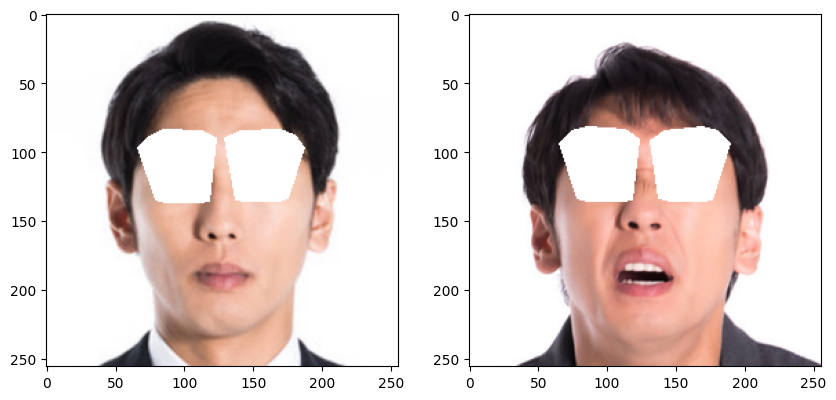

In [100]:
import matplotlib.pyplot as plt

fill_color = (255,255,255)
cv2.fillPoly(img_eye_from, [pt_eye_left_from], fill_color)
cv2.fillPoly(img_eye_from, [pt_eye_right_from], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_left_to], fill_color)
cv2.fillPoly(img_eye_to, [pt_eye_right_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_eye_from)
ax[1].imshow(img_eye_to)

plt.show()

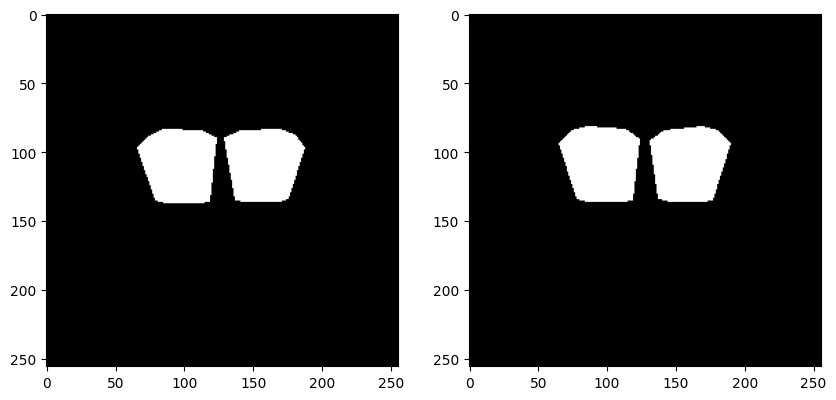

In [101]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_eye_from = cv2.fillPoly(mask.copy(), [pt_eye_left_from], (255,255,255))
cv2.fillPoly(mask_eye_from, [pt_eye_right_from], (255,255,255))
mask_eye_to = cv2.fillPoly(mask.copy(), [pt_eye_left_to], (255,255,255))
cv2.fillPoly(mask_eye_to, [pt_eye_right_to], (255,255,255))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_eye_from)
ax[1].imshow(mask_eye_to)
plt.show()

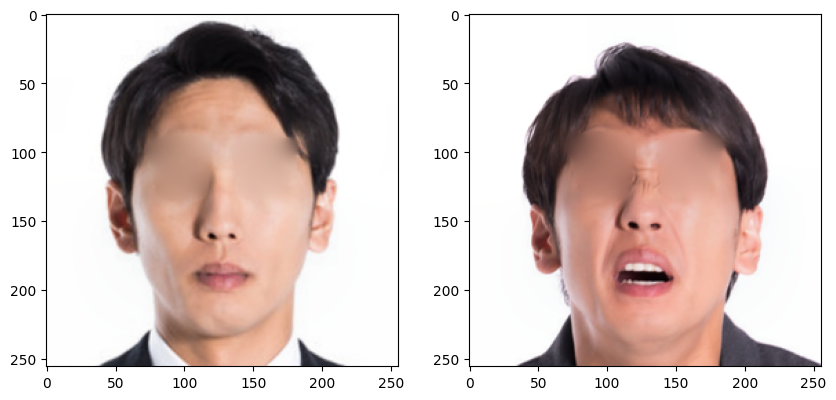

In [102]:
eyeless_from = cv2.illuminationChange(IMAGES[0], mask_eye_from, alpha = 1.5, beta = 2)
eyeless_to = cv2.illuminationChange(IMAGES[1], mask_eye_to, alpha = 1.5, beta = 2)                          

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eyeless_from)
ax[1].imshow(eyeless_to)
plt.show()

In [103]:
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[0]}/eyeless.png',
            cv2.cvtColor(eyeless_from, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[1]}/eyeless.png',
            cv2.cvtColor(eyeless_to, cv2.COLOR_RGB2BGR));

## Mouth

In [104]:
img_mouth_from = IMAGES[0].copy()
img_mouth_to = IMAGES[1].copy()
pt_mouth_from = lm[0,48:60].copy()
pt_mouth_to = lm[1,48:60].copy()

In [105]:
pt_mouth_from_center = pt_mouth_from.sum(axis=0)//len(pt_mouth_from)
for i in range(len(pt_mouth_from)):
    if pt_mouth_from[i][0] < pt_mouth_from_center[0]:
        pt_mouth_from[i][0] -= 15
    else:
        pt_mouth_from[i][0] += 15
    
    if pt_mouth_from[i][1] < pt_mouth_from_center[1]:
        pt_mouth_from[i][1] -= 10
    else:
        pt_mouth_from[i][1] += 10 

pt_mouth_to_center = pt_mouth_to.sum(axis=0)//len(pt_mouth_to)
for i in range(len(pt_mouth_to)):
    if pt_mouth_to[i][0] < pt_mouth_to_center[0]:
        pt_mouth_to[i][0] -= 15
    else:
        pt_mouth_to[i][0] += 15
    
    if pt_mouth_to[i][1] < pt_mouth_to_center[1]:
        pt_mouth_to[i][1] -= 10
    else:
        pt_mouth_to[i][1] += 10

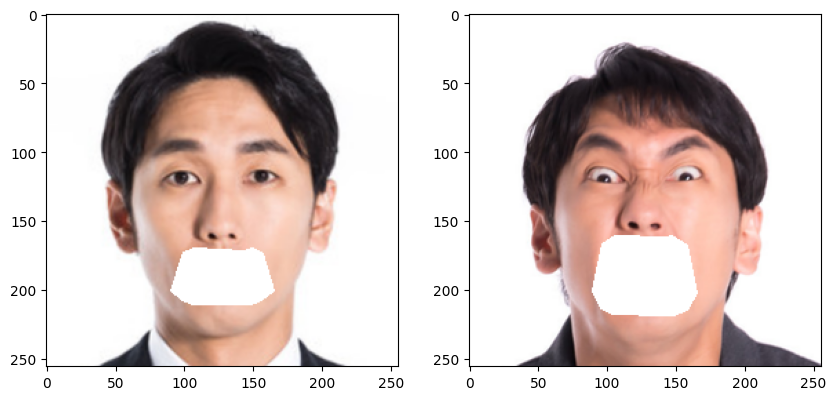

In [106]:
import matplotlib.pyplot as plt

fill_color = (255,255,255)
cv2.fillPoly(img_mouth_from, [pt_mouth_from], fill_color)
cv2.fillPoly(img_mouth_to, [pt_mouth_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_mouth_from)
ax[1].imshow(img_mouth_to)

plt.show()

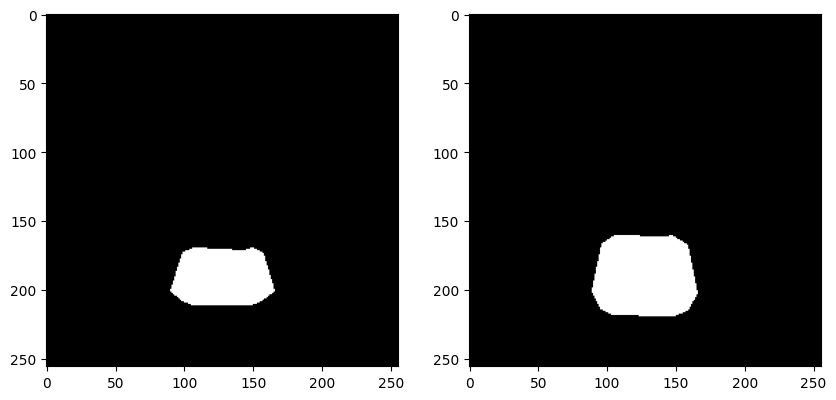

In [107]:
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
mask_mouth_from = cv2.fillPoly(mask.copy(), [pt_mouth_from], (255,255,255))
mask_mouth_to = cv2.fillPoly(mask.copy(), [pt_mouth_to], (255,255,255))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_mouth_from)
ax[1].imshow(mask_mouth_to)
plt.show()

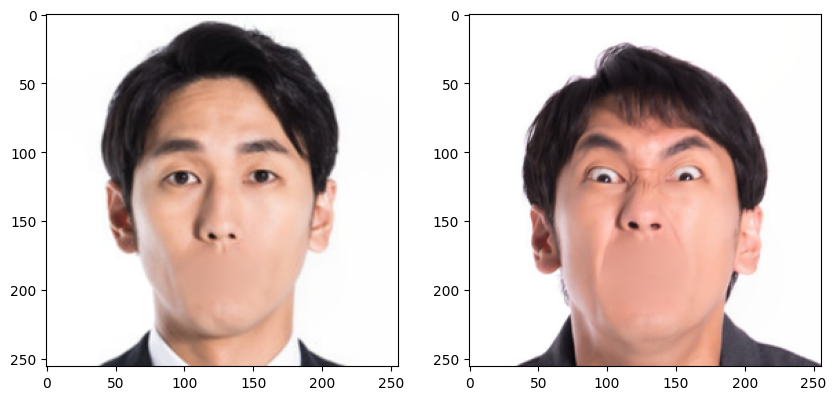

In [108]:
mouthless_from = cv2.illuminationChange(IMAGES[0], mask_mouth_from, alpha = 1.5, beta = 2)
mouthless_to = cv2.illuminationChange(IMAGES[1], mask_mouth_to, alpha = 1.5, beta = 2)                          

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mouthless_from)
ax[1].imshow(mouthless_to)
plt.show()

In [109]:
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[0]}/mouthless.png',
            cv2.cvtColor(mouthless_from, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[1]}/mouthless.png',
            cv2.cvtColor(mouthless_to, cv2.COLOR_RGB2BGR));

## Eye&Mouth

Eye, Mouthを実行してから

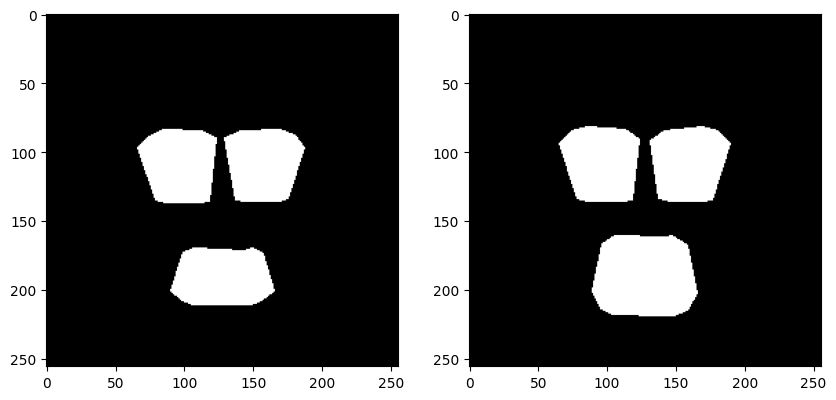

In [110]:
mask_eye_mouth_from = cv2.fillPoly(mask_eye_from.copy(), [pt_mouth_from], (255,255,255))
mask_eye_mouth_to = cv2.fillPoly(mask_eye_to.copy(), [pt_mouth_to], (255,255,255))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_eye_mouth_from)
ax[1].imshow(mask_eye_mouth_to)
plt.show()

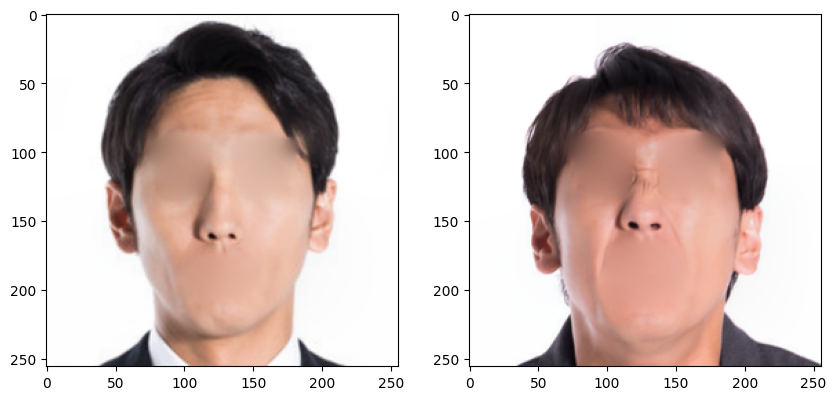

In [111]:
eye_mouth_less_from = cv2.illuminationChange(IMAGES[0], mask_eye_mouth_from, alpha = 1.5, beta = 2)
eye_mouth_less_to = cv2.illuminationChange(IMAGES[1], mask_eye_mouth_to, alpha = 1.5, beta = 2)                          

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(eye_mouth_less_from)
ax[1].imshow(eye_mouth_less_to)
plt.show()

In [112]:
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[0]}/eye_mouth_less.png',
            cv2.cvtColor(eye_mouth_less_from, cv2.COLOR_RGB2BGR))
cv2.imwrite(f'{dst_dir}{IMAGES_NAME[1]}/eye_mouth_less.png',
            cv2.cvtColor(eye_mouth_less_to, cv2.COLOR_RGB2BGR));

## 合成

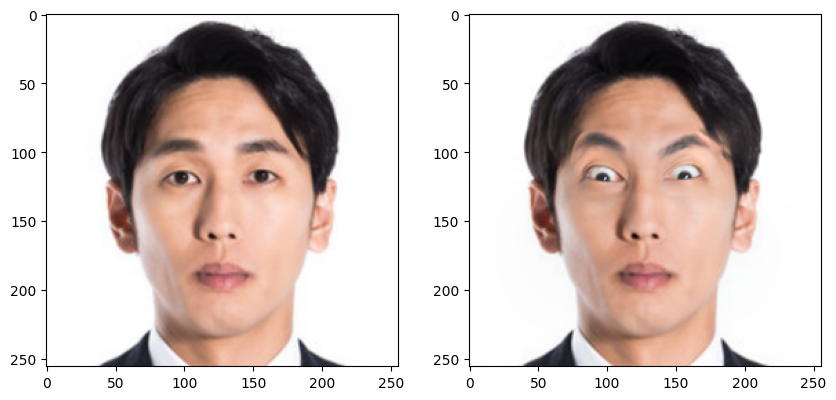

In [124]:
p = (pt_eye_left_from_center + pt_eye_right_from_center)//2
result = cv2.seamlessClone(IMAGES[1], eyeless_from, mask_eye_to, p, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(result)
plt.show()

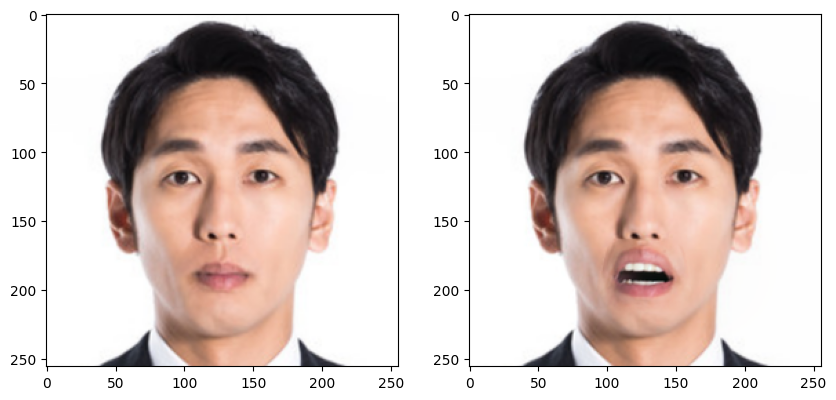

In [130]:
p = pt_mouth_from_center
result = cv2.seamlessClone(IMAGES[1], mouthless_from, mask_mouth_to, p, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(result)
plt.show()

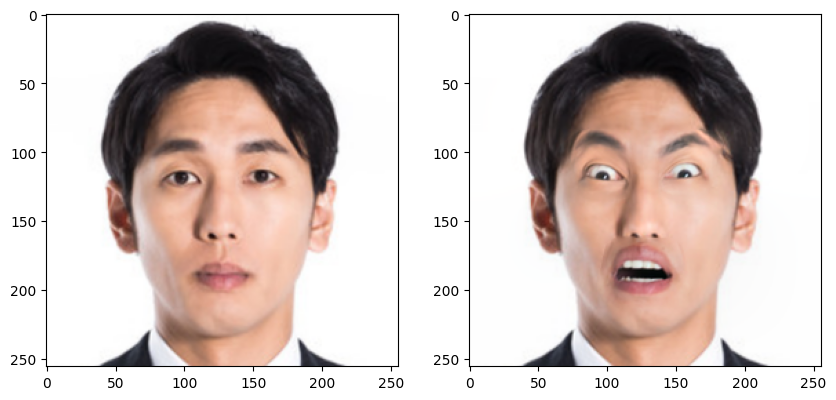

In [137]:
p = ((pt_eye_left_from_center + pt_eye_right_from_center)//2 + pt_mouth_from_center)//2
result = cv2.seamlessClone(IMAGES[1], eye_mouth_less_from, mask_eye_mouth_to, p, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(result)
plt.show()